In [1]:
import celmech as cm
import rebound as rb
import numpy as np
from test_particle_secular_hamiltonian import SyntheticSecularTheory, TestParticleSecularHamiltonian
from celmech.miscellaneous import frequency_modified_fourier_transform as fmft
from matplotlib import pyplot as plt
from celmech.poisson_series import PoissonSeriesHamiltonian 

In [2]:
import pickle
with open("solar_system_synthetic_solution.bin","rb") as fi:
    solar_system_synthetic_theory=pickle.load(fi)

In [3]:
truncate_dictionary = lambda d,tol: {key:val for key,val in d.items() if np.abs(val)>tol}
simpler_secular_theory = SyntheticSecularTheory(
    solar_system_synthetic_theory.masses,
    solar_system_synthetic_theory.semi_major_axes,
    solar_system_synthetic_theory.omega_vector,
    [truncate_dictionary(x_d,1e-3) for x_d in solar_system_synthetic_theory.x_dicts],
    [truncate_dictionary(y_d,1e-3) for y_d in solar_system_synthetic_theory.y_dicts]
)

Searching NASA Horizons for 'Sun'... 
Found: Sun (10) 
Searching NASA Horizons for 'Jupiter'... 
Found: Jupiter Barycenter (5) (chosen from query 'Jupiter')
Searching NASA Horizons for 'Saturn'... 
Found: Saturn Barycenter (6) (chosen from query 'Saturn')
Searching NASA Horizons for 'Uranus'... 
Found: Uranus Barycenter (7) (chosen from query 'Uranus')
Searching NASA Horizons for 'Neptune'... 
Found: Neptune Barycenter (8) (chosen from query 'Neptune')
Searching NASA Horizons for 'Vesta'... 
Found: 4 Vesta (A807 FA) 


/Users/hadden/miniconda3/envs/celmech/lib/python3.13/site-packages/rebound/horizons.py:172: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)
/Users/hadden/miniconda3/envs/celmech/lib/python3.13/site-packages/rebound/simulationarchive.py:152: RuntimeWarning: The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().
  warnings.warn("The simulation might not be synchronized. You can manually synchronize it by calling sim.integrator_synchronize().", RuntimeWarning)


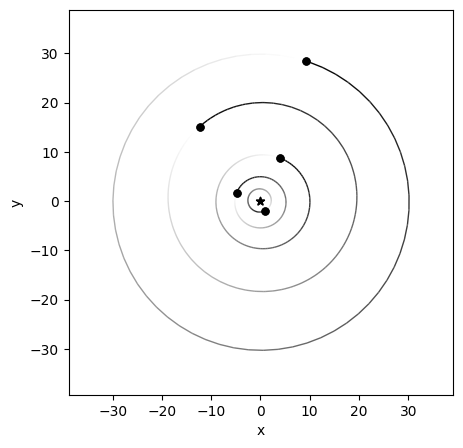

In [4]:
sim = rb.Simulation()
sim.add("Sun")
sim.add("Jupiter")
sim.add("Saturn")
sim.add("Uranus")
sim.add("Neptune")
sim.N_active = sim.N
# add some asteroids
sim.add("Vesta")
sim.move_to_com()
cm.nbody_simulation_utilities.align_simulation(sim)
rb.OrbitPlot(sim)
try:
    results = cm.nbody_simulation_utilities.get_simarchive_integration_results("vesta+outer_solar_system.sa",coordinates='heliocentric')
except:
    sim.integrator = 'whfast'
    sim.dt = np.min([p.P for p in sim.particles[1:]]) / 25.
    sim.ri_whfast.safe_mode = 0
    Tfin_approx = 0.5e7 * 2*np.pi
    total_steps = np.ceil(Tfin_approx / sim.dt)
    Tfin = total_steps * sim.dt + sim.dt
    Nout = 4096
    sim.save_to_file("vesta+outer_solar_system.sa",step=int(np.floor(total_steps/Nout)),delete_file=True)
    sim.integrate(Tfin,exact_finish_time=0)
    results = cm.nbody_simulation_utilities.get_simarchive_integration_results("vesta+outer_solar_system.sa",coordinates='heliocentric')

In [5]:
results['X'] = np.sqrt(2*(1-np.sqrt(1-results['e']**2))) * np.exp(1j * results['pomega'])
results['Y'] = (1-results['e']**2)**(0.25) * np.sin(0.5 * results['inc'] ) * np.exp(1j * results['Omega'])

In [6]:
tp_h = TestParticleSecularHamiltonian(np.mean(results['a'][-1]),simpler_secular_theory)
x_numerical = results['X'][-1]
y_numerical = 2*results['Y'][-1]
x_linear,y_linear = tp_h.linear_theory_solution(x_numerical[0],y_numerical[0],results['time'])

# Build `PoissonSeriesHamiltonian` from 4th order expansion


In [7]:
from celmech.disturbing_function import list_secular_terms
from celmech.poisson_series import PoissonSeries

# leading order Hamiltonian
h2_series = tp_h.H2_poisson_series()

# list of 4th order terms
sec_terms = list_secular_terms(4,4)
h4_series = PoissonSeries(2,tp_h.synthetic_secular_theory.N_freq)
for k,nu in sec_terms:
    for i in range(tp_h.synthetic_secular_theory.N_planets):
        h4_series+=tp_h.DFTerm_poisson_series(i,k,nu)

# Strip terms that only depend on angles and not x,y,\bar{x},\bar{y}
angle_only_term  = lambda term: (np.all(term.k==0) and np.all(term.kbar==0))
h4_series_reduced = PoissonSeries.from_PSTerms([term for term in h4_series.terms if not angle_only_term(term)])

# Hamiltonian
h_tot = h2_series + h4_series_reduced
print("{} terms total".format(len(h_tot.terms)))
ham_ps = PoissonSeriesHamiltonian(h_tot)

704 terms total


In [10]:
from celmech.rk_integrator import RKIntegrator

In [11]:
dt = 0.1 * np.min(2*np.pi / np.abs((tp_h.g0,tp_h.s0)))

In [12]:
integrator = RKIntegrator(
    ham_ps.flow,
    ham_ps.flow_and_jacobian,
    Ndim=2*(ham_ps.N+ham_ps.M),
    dt=dt,
    rtol=1e-4,
    atol=1e-7,
    rk_method='GL6',
    rk_root_method='Newton',
    max_iter=10
)


### numerically integrate 4th order Hamiltonian

In [13]:
u0 = x_numerical[0] - np.sum(list(tp_h.F_e.values()))
v0 = y_numerical[0] - np.sum(list(tp_h.F_inc.values()))
_RT2 = np.sqrt(2)
X = np.zeros(2*(h_tot.M+h_tot.N))
X[:2] = -1 * _RT2 * np.imag(np.array([u0,v0]))
X[h_tot.M+h_tot.N:h_tot.M+h_tot.N+2] = _RT2 * np.real(np.array([u0,v0]))

steps = 200
times = np.arange(steps) * integrator.dt
X_rk = np.zeros((steps,X.size))
for i in range(steps):
    X_rk[i] = X
    X = integrator.rk_step(X)


In [14]:
from scipy.integrate import solve_ivp
Tfin = 0.1e6 * 2*np.pi
Nout = 200
t_eval = np.linspace(0,Tfin,Nout)
soln_h = solve_ivp(
    lambda t,y: ham_ps.flow(y),
    (0,Tfin),
    X_rk[0],
    method="Radau",
    t_eval=t_eval,
    jac = lambda t,y: ham_ps.jacobian(y)
)

# Plot comparison of solutions

Text(0.5, 1.0, 'Vesta secular evolution')

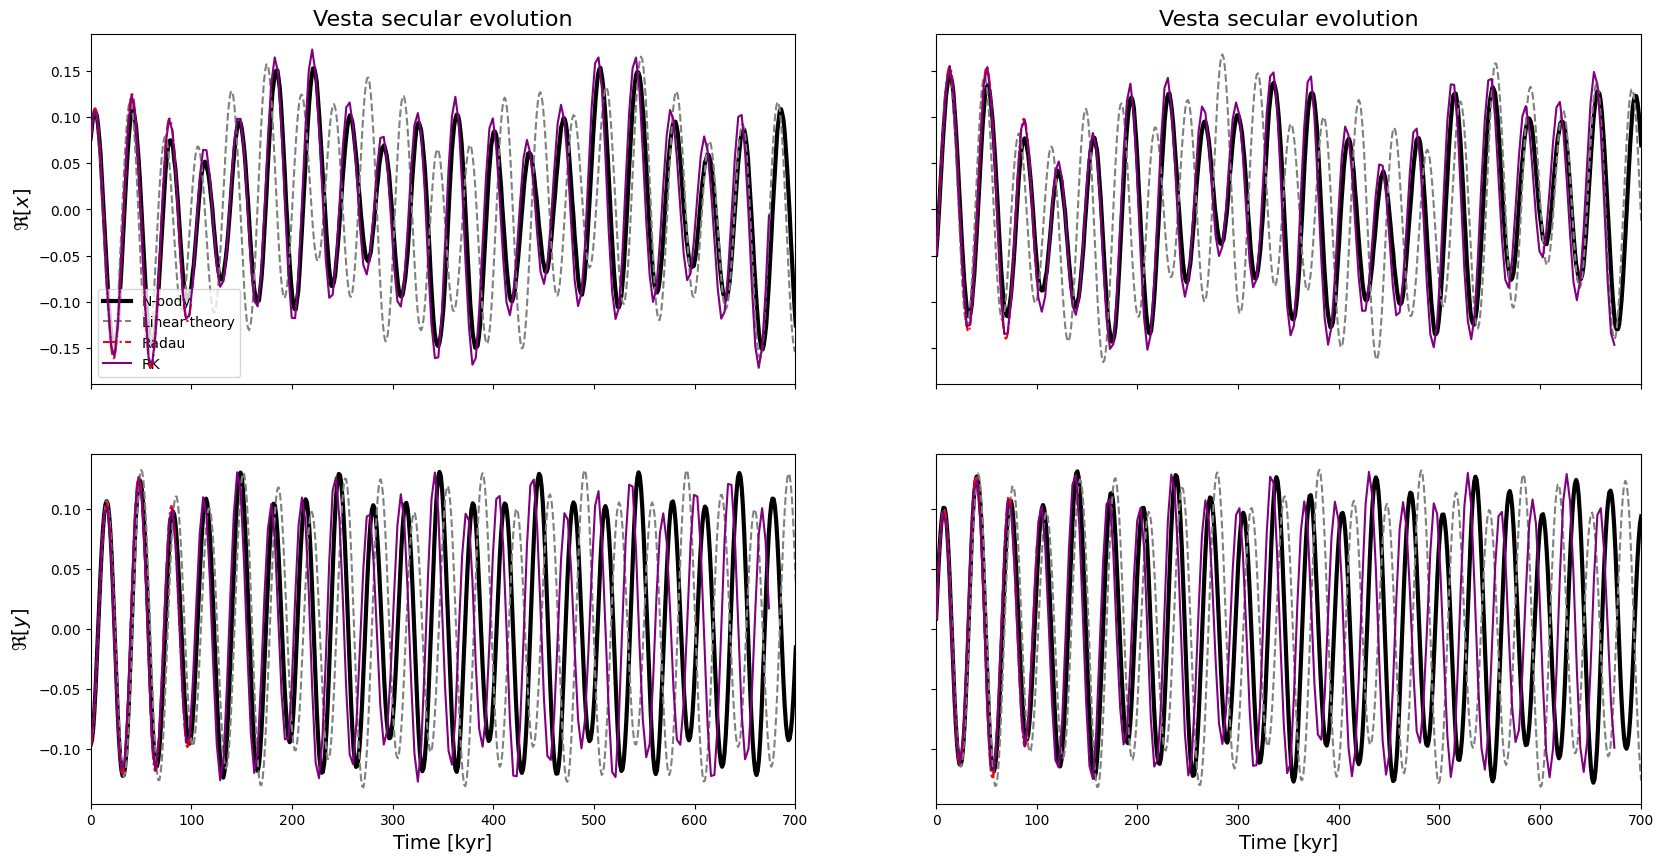

In [17]:
u_soln = (soln_h.y[h_tot.M+h_tot.N] - 1j * soln_h.y[0]) / np.sqrt(2)
F_e_soln = np.sum([amp*np.exp(1j*(m @ soln_h.y[h_tot.N:h_tot.M+h_tot.N])) for m,amp in tp_h.F_e.items()],axis=0)    
x_soln = u_soln+F_e_soln

v_soln = (soln_h.y[1+h_tot.M+h_tot.N] - 1j * soln_h.y[1]) / np.sqrt(2)
F_inc_soln = np.sum([amp*np.exp(1j*(m @ soln_h.y[h_tot.N:h_tot.M+h_tot.N])) for m,amp in tp_h.F_inc.items()],axis=0)    
y_soln = v_soln+F_inc_soln

u_rk_soln = (X_rk.T[h_tot.M+h_tot.N] - 1j * X_rk.T[0]) / np.sqrt(2)
F_e_rk_soln = np.sum([amp*np.exp(1j*(m @ X_rk.T[h_tot.N:h_tot.M+h_tot.N])) for m,amp in tp_h.F_e.items()],axis=0)    
x_rk_soln = u_rk_soln+F_e_rk_soln

v_rk_soln = (X_rk.T[1+h_tot.M+h_tot.N] - 1j * X_rk.T[1]) / np.sqrt(2)

F_inc_rk_soln = np.sum([amp*np.exp(1j*(m @ X_rk.T[h_tot.N:h_tot.M+h_tot.N])) for m,amp in tp_h.F_inc.items()],axis=0)    

y_rk_soln = v_rk_soln+F_inc_rk_soln

fig,ax = plt.subplots(2,2,sharex=True,figsize=(20,10),sharey='row')

for j,fn in zip((0,1),(np.real,np.imag)):
    ax[0,j].plot(results['time']/(2e3*np.pi),fn(x_numerical),lw=3,color='k',label="N-body")
    ax[0,j].plot(results['time']/(2e3*np.pi),fn(x_linear),'--',color='gray',label="Linear theory")
    ax[0,j].plot(soln_h.t/(2e3*np.pi),fn(x_soln),'r-.',zorder=99,label="Radau")
    ax[0,j].plot(times/(2e3*np.pi),fn(x_rk_soln),'-',color='purple',zorder=99,label="RK")

    ax[1,j].plot(results['time']/(2e3*np.pi),fn(y_numerical),lw=3,color='k')
    ax[1,j].plot(results['time']/(2e3*np.pi),fn(y_linear),'--',color='gray')
    ax[1,j].plot(soln_h.t/(2e3*np.pi),fn(y_soln),'r-.',zorder=99)
    ax[1,j].plot(times/(2e3*np.pi),fn(y_rk_soln),'-',color='purple',zorder=99,label="RK")

ax[0,0].legend(loc = 'lower left')
plt.xlim(0,.7e3)

ax[1,0].set_xlabel("Time [kyr]",fontsize=14)
ax[1,1].set_xlabel("Time [kyr]",fontsize=14)
ax[0,0].set_ylabel(r"$\Re[x]$",fontsize=14)
ax[1,0].set_ylabel(r"$\Re[y]$",fontsize=14)
ax[0,0].set_title("Vesta secular evolution",fontsize=16)
ax[0,1].set_title("Vesta secular evolution",fontsize=16)

Leading order approximation of proper e (non-constant behaviour due to nonlinear order term corrections)

In [ ]:
plt.plot(times/(2e3*np.pi),np.abs(u_rk_soln))
plt.plot(soln_h.t/(2e3*np.pi),np.abs(u_soln))

# check energy conservation

In [ ]:
# Radau is not great; something fishy going on!?
energy = np.array([ham_ps(yy) for yy in X_rk])
plt.plot(times/(2*np.pi),np.abs(energy/energy[0] - 1),label='implicit rk GL6')
energy = np.array([ham_ps(yy) for yy in soln_h.y.T])
plt.plot(soln_h.t/(2*np.pi),np.abs(energy/energy[0] - 1),label='radau')
plt.yscale('log')
plt.legend()
plt.ylim(ymin=0.4e-6)
plt.xlabel("Time [yr]",fontsize=14)
plt.ylabel(r"$|\Delta E / E|$",fontsize=14)